# Aprroximate q-learning

In this notebook you will teach a pytorch neural network to do Q-learning.

In [1]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


2


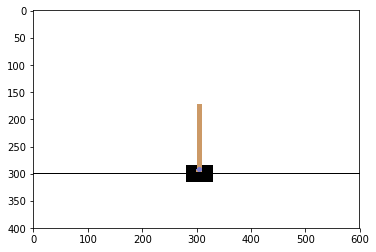

In [19]:
env = gym.make("CartPole-v1").env
n_actions = env.action_space.n
env.reset()
print(n_actions)
state_dim = env.observation_space.shape

plt.imshow(env.render("rgb_array"))
env.close()

## Approximate Q-learning: building the network

To train a neural network policy one must have a neural network policy. Let's build it.

Since we're working with a pre-extracted featuews (cart positions, angles and velocities), we don't need a complicated network yet. In fact, let's build something like this for starters: 

 (state - batch of 4d feature vectors) - > (network body - one or several linear layers with nonlinearities) ->  (Q(s, a0), Q(s, a1), Q(s, ...)- a single linear(dense) layer, linear activarion, n_action units)


For your first run, please use only linear layers (nn.Linear) and activations. Stuff like batch normalization or dropout might ruin everything.

Also avoid using nonlinearities like sigmoid & tanh: agent's observations are not normalized so sigmoid may become saturated from init.

Ideally you should start small with maybe 1-2 hidden layers with <200 neurons and then increase network size if agent doesn't beat the target score.


In [4]:
print("state_dim ", state_dim)
print("n_actions ", n_actions)

state_dim  (4,)
n_actions  2


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable


In [7]:
network = nn.Sequential()

network.add_module('layer1', nn.Linear(state_dim[0], 42))
network.add_module('nonlinear', nn.ReLU())
# network.add_module('layer_output', nn.Linear())
# hint: use state_dim[0] as input size
network.add_module('hidden', nn.Linear(42, 42))

network.add_module('hidden2', nn.Linear(42, 42))
network.add_module('nonlinear2', nn.ReLU())
network.add_module('q_values', nn.Linear(42, n_actions))



In [8]:
def get_action(state, epsilon=0):
    """
    sample actions with epsilon-greedy policy
    recap: with p = epsilon pick random action, else pick action with highest Q(s,a)
    """
    state = torch.tensor(state[None], dtype=torch.float32)
    q_values = network(state).detach().numpy()
    if np.random.random() < epsilon:
        action = np.random.choice(n_actions)
    else:
        action = np.argmax(q_values)

    return int(action)

In [9]:
s = env.reset()
assert tuple(network(torch.tensor([s]*3, dtype=torch.float32)).size()) == (    3, n_actions), \
    "please make sure your model maps state s -> [Q(s,a0), ..., Q(s, a_last)]"
assert isinstance(list(network.modules())[-1], nn.Linear), \
    "please make sure you predict q-values without nonlinearity (ignore if you know what you're doing)"
assert isinstance(get_action(
    s), int), "get_action(s) must return int, not %s. try int(action)" % (type(get_action(s)))

# test epsilon-greedy exploration
for eps in [0., 0.1, 0.5, 1.0]:
    state_frequencies = np.bincount(
        [get_action(s, epsilon=eps) for i in range(10000)], minlength=n_actions)
    best_action = state_frequencies.argmax()
    assert abs(state_frequencies[best_action] -
               10000 * (1 - eps + eps / n_actions)) < 200
    for other_action in range(n_actions):
        if other_action != best_action:
            assert abs(state_frequencies[other_action] -
                       10000 * (eps / n_actions)) < 200
    print('e=%.1f tests passed' % eps)


e=0.0 tests passed


e=0.1 tests passed


e=0.5 tests passed


e=1.0 tests passed


### Q-learning via gradient descent

We shall now train our agent's Q-function by minimizing the TD loss:
$$ L = { 1 \over N} \sum_i (Q_{\theta}(s,a) - [r(s,a) + \gamma \cdot max_{a'} Q_{-}(s', a')]) ^2 $$


Where
* $s, a, r, s'$ are current state, action, reward and next state respectively
* $\gamma$ is a discount factor defined two cells above.

The tricky part is with  $Q_{-}(s',a')$. From an engineering standpoint, it's the same as $Q_{\theta}$ - the output of your neural network policy. However, when doing gradient descent, __we won't propagate gradients through it__ to make training more stable (see lectures).

To do so, we shall use `x.detach()` function which basically says "consider this thing constant when doingbackprop".

In [10]:
def to_one_hot(y_tensor, n_dims=None):
    """ helper: take an integer vector and convert it to 1-hot matrix. """
    y_tensor = y_tensor.type(torch.LongTensor).view(-1, 1)
    n_dims = n_dims if n_dims is not None else int(torch.max(y_tensor)) + 1
    y_one_hot = torch.zeros(
        y_tensor.size()[0], n_dims).scatter_(1, y_tensor, 1)
    return y_one_hot


def where(cond, x_1, x_2):
    """ helper: like np.where but in pytorch. """
    return (cond * x_1) + ((1-cond) * x_2)

In [11]:
def compute_td_loss(states, actions, rewards, next_states, is_done, gamma=0.99, check_shapes=False):
    """ Compute td loss using torch operations only. Use the formula above. """
    states = torch.tensor(states, dtype=torch.float32)    # shape: [batch_size, state_size]
    actions = torch.tensor(actions, dtype=torch.int32)    # shape: [batch_size]
    rewards = torch.tensor(rewards, dtype=torch.float32)  # shape: [batch_size]
    # shape: [batch_size, state_size]
    next_states = torch.tensor(next_states, dtype=torch.float32)
    is_done = torch.tensor(is_done, dtype=torch.float32)  # shape: [batch_size]

    # get q-values for all actions in current states
    predicted_qvalues = network.forward(states)

    # select q-values for chosen actions
    predicted_qvalues_for_actions = torch.sum(
        predicted_qvalues * to_one_hot(actions, n_actions), dim=1)
    # compute q-values for all actions in next states
    predicted_next_qvalues = network.forward(next_states)
    
    # compute V*(next_states) using predicted next q-values
    next_state_values = torch.max(predicted_next_qvalues, dim=1)[0]
    # take [0] element since max returns indexes as [1] element
    assert next_state_values.dtype == torch.float32

    # compute "target q-values" for loss - it's what's inside square parentheses in the above formula.
    target_qvalues_for_actions = rewards + gamma * next_state_values
    # at the last state we shall use simplified formula: Q(s,a) = r(s,a) since s' doesn't exist
    target_qvalues_for_actions = where(is_done, rewards, target_qvalues_for_actions)

    # mean squared error loss to minimize
    loss = torch.mean((predicted_qvalues_for_actions -
                       target_qvalues_for_actions.detach()) ** 2)
    if check_shapes:
        assert predicted_next_qvalues.data.dim(
        ) == 2, "make sure you predicted q-values for all actions in next state"
        assert next_state_values.data.dim(
        ) == 1, "make sure you computed V(s') as maximum over just the actions axis and not all axes"
        assert target_qvalues_for_actions.data.dim(
        ) == 1, "there's something wrong with target q-values, they must be a vector"

    return loss

In [12]:
# sanity checks
s = env.reset()
a = env.action_space.sample()
next_s, r, done, _ = env.step(a)
loss = compute_td_loss([s], [a], [r], [next_s], [done], check_shapes=True)
loss.backward()

assert len(loss.size()) == 0, "you must return scalar loss - mean over batch"
assert np.any(next(network.parameters()).grad.detach().numpy() !=
              0), "loss must be differentiable w.r.t. network weights"

##Playing the game

In [13]:
opt = torch.optim.Adam(network.parameters(), lr=1e-4)
epsilon = 0.5


In [14]:
def generate_session(t_max=1000, epsilon=0, train=False):
    """play env with approximate q-learning agent and train it at the same time"""
    total_reward = 0
    s = env.reset()

    for t in range(t_max):
        a = get_action(s, epsilon=epsilon)
        next_s, r, done, _ = env.step(a)

        if train:
            opt.zero_grad()
            compute_td_loss([s], [a], [r], [next_s], [done]).backward()
            opt.step()

        total_reward += r
        s = next_s
        if done:
            break

    return total_reward

In [15]:
for i in range(1000):
    session_rewards = [generate_session(
        epsilon=epsilon, train=True) for _ in range(50)]
    print("epoch #{}\tmean reward = {:.3f}\tepsilon = {:.3f}".format(
        i, np.mean(session_rewards), epsilon))

    epsilon *= 0.99
    assert epsilon >= 1e-4, "Make sure epsilon is always nonzero during training"

    if np.mean(session_rewards) > 300:
        print("You Win!")
        break

epoch #0	mean reward = 13.980	epsilon = 0.500


epoch #1	mean reward = 14.160	epsilon = 0.495


epoch #2	mean reward = 12.940	epsilon = 0.490


epoch #3	mean reward = 13.680	epsilon = 0.485


epoch #4	mean reward = 12.360	epsilon = 0.480


epoch #5	mean reward = 12.360	epsilon = 0.475


epoch #6	mean reward = 12.920	epsilon = 0.471


epoch #7	mean reward = 13.520	epsilon = 0.466


epoch #8	mean reward = 13.740	epsilon = 0.461


epoch #9	mean reward = 13.280	epsilon = 0.457


epoch #10	mean reward = 12.200	epsilon = 0.452


epoch #11	mean reward = 13.780	epsilon = 0.448


epoch #12	mean reward = 18.140	epsilon = 0.443


epoch #13	mean reward = 13.900	epsilon = 0.439


epoch #14	mean reward = 17.660	epsilon = 0.434


epoch #15	mean reward = 23.240	epsilon = 0.430


epoch #16	mean reward = 25.040	epsilon = 0.426


epoch #17	mean reward = 29.360	epsilon = 0.421


epoch #18	mean reward = 34.360	epsilon = 0.417


epoch #19	mean reward = 34.380	epsilon = 0.413


epoch #20	mean reward = 37.820	epsilon = 0.409


epoch #21	mean reward = 33.540	epsilon = 0.405


epoch #22	mean reward = 47.080	epsilon = 0.401


epoch #23	mean reward = 47.540	epsilon = 0.397


epoch #24	mean reward = 47.740	epsilon = 0.393


epoch #25	mean reward = 40.240	epsilon = 0.389


epoch #26	mean reward = 51.260	epsilon = 0.385


epoch #27	mean reward = 59.940	epsilon = 0.381


epoch #28	mean reward = 45.400	epsilon = 0.377


epoch #29	mean reward = 55.640	epsilon = 0.374


epoch #30	mean reward = 50.860	epsilon = 0.370


epoch #31	mean reward = 55.920	epsilon = 0.366


epoch #32	mean reward = 51.700	epsilon = 0.362


epoch #33	mean reward = 49.140	epsilon = 0.359


epoch #34	mean reward = 57.880	epsilon = 0.355


epoch #35	mean reward = 50.580	epsilon = 0.352


epoch #36	mean reward = 61.420	epsilon = 0.348


epoch #37	mean reward = 54.460	epsilon = 0.345


epoch #38	mean reward = 65.940	epsilon = 0.341


epoch #39	mean reward = 69.260	epsilon = 0.338


epoch #40	mean reward = 72.160	epsilon = 0.334


epoch #41	mean reward = 74.720	epsilon = 0.331


epoch #42	mean reward = 85.620	epsilon = 0.328


epoch #43	mean reward = 120.180	epsilon = 0.325


epoch #44	mean reward = 145.520	epsilon = 0.321


epoch #45	mean reward = 190.680	epsilon = 0.318


epoch #46	mean reward = 207.400	epsilon = 0.315


epoch #47	mean reward = 196.740	epsilon = 0.312


epoch #48	mean reward = 73.100	epsilon = 0.309


epoch #49	mean reward = 50.940	epsilon = 0.306


epoch #50	mean reward = 67.780	epsilon = 0.303


epoch #51	mean reward = 105.000	epsilon = 0.299


epoch #52	mean reward = 78.160	epsilon = 0.296


epoch #53	mean reward = 51.440	epsilon = 0.294


epoch #54	mean reward = 51.940	epsilon = 0.291


epoch #55	mean reward = 43.720	epsilon = 0.288


epoch #56	mean reward = 45.960	epsilon = 0.285


epoch #57	mean reward = 124.940	epsilon = 0.282


epoch #58	mean reward = 272.300	epsilon = 0.279


epoch #59	mean reward = 476.280	epsilon = 0.276
You Win!



   * mean reward is the average reward per game. For a correct implementation it may stay low for some 10 epochs, then start growing while oscilating insanely and converges by ~50-100 steps depending on the network architecture.
   * If it never reaches target score by the end of for loop, try increasing the number of hidden neurons or look at the epsilon.
   * epsilon - agent's willingness to explore. If you see that agent's already at < 0.01 epsilon before it's is at least 200, just reset it back to 0.1 - 0.5.


## Record videos
As usual, we now use gym.wrappers.Monitor to record a video of our agent playing the game. Unlike our previous attempts with state binarization, this time we expect our agent to act (or fail) more smoothly since there's no more binarization error at play.

As you already did with tabular q-learning, we set epsilon=0 for final evaluation to prevent agent from exploring himself to death.

In [16]:
# record sessions
import gym.wrappers
env = gym.wrappers.Monitor(gym.make("CartPole-v0"),
                           directory="videos", force=True)
sessions = [generate_session(epsilon=0, train=False) for _ in range(100)]
env.close()

In [18]:

# show video
from IPython.display import HTML
import os

video_names = list(
    filter(lambda s: s.endswith(".mp4"), os.listdir("./videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[-1]))  # this may or may not be _last_ video.

<video width="640" height="480" controls>
  <source src="./videos/openaigym.video.0.5756.video000064.mp4" type="video/mp4">
</video>